# TensorFlow SR 波形预处理
这个 notebook 里面介绍了一种波形预处理的方法，预处理主要分为三个部分：
- 1，对杂音的过滤
- 2，将开始和最末尾的没有信号的部分去除
- 3，降维和重采样

In [1]:
from scipy.io import wavfile
from scipy import signal
import re
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

## 首先导入数据
数据下载地址：https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

下载下来的数据集数据集我们存放在一个叫做 dataset 的文件夹下面，结构如下
```
+-- dataset
|   +-- test            # extracted
|   |   +-- audio       # all test
|   +-- test.7z         # downloaded
|   +-- train           # extracted
|   |   +-- audio       # folder with all train command/file.wav
|   |   +-- LICENSE
|   |   +-- README.md
|   |   +-- testing_list.txt
|   |   +-- validation_list.txt
|   +-- train.7z        # downloaded
+-- readme.md
+-- Data Preprocessing.ipynb
```

In [2]:
DATADIR = './dataset'  # unzipped train and test data
POSSIBLE_LABELS = ('bed bird cat dog down eight five four go ' +
                   'happy house left marvin name.txt nine no ' +
                   'off on one right seven sheila six stop three ' +
                   'tree two up wow yes zero silence unknown').split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}

In [3]:
def load_data(data_dir):
    pattern = re.compile("(.+\/)?(\w+)\/([^_]+)_.+wav")
    all_files = glob(os.path.join(data_dir, 'train/audio/*/*wav'))

    with open(os.path.join(data_dir, 'train/validation_list.txt'), 'r') as fin:
        validation_files = fin.readlines()
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))

    possible = set(POSSIBLE_LABELS)
    train, val = [], []
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, uid = r.group(2), r.group(3)
            if label == '_background_noise_':
                label = 'silence'
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]

            sample = (label_id, uid, entry)
            if uid in valset:
                val.append(sample)
            else:
                train.append(sample)

    print('There are {} train and {} val samples'.format(len(train), len(val)))
    return train, val

In [4]:
train, val = load_data(DATADIR)

There are 57929 train and 6798 val samples


## 看一下数据长什么样子

In [5]:
# Get wav in numeric series
def read_wav(fname):
    try:
        _, wav = wavfile.read(fname)
        wav = wav.astype(np.float32) / np.iinfo(np.int16).max
        return wav
    except Exception as err:
        print(err, fname)

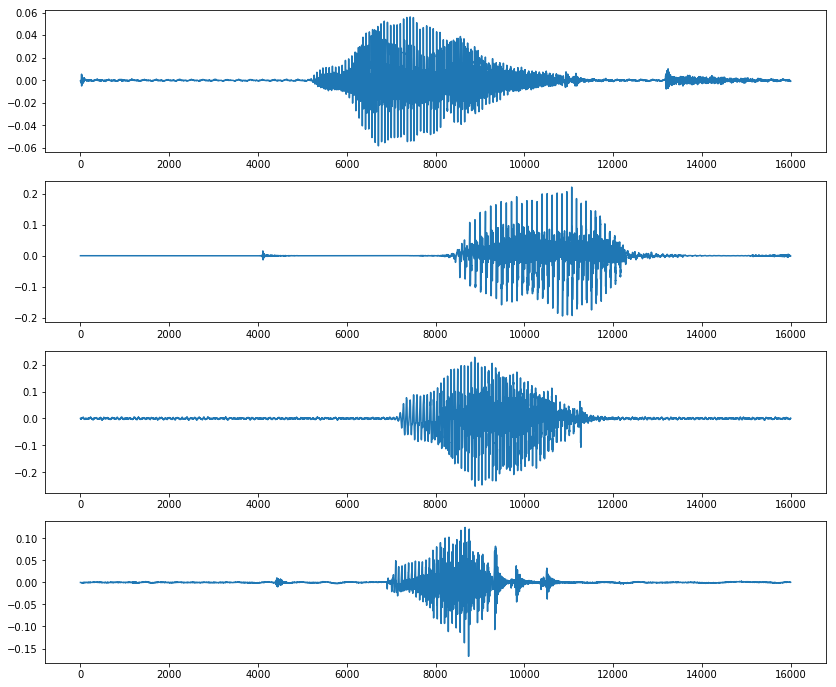

In [24]:
# Read the first 4 wav data
wav_1 = read_wav(train[0][2])
wav_2 = read_wav(train[1][2])
wav_3 = read_wav(train[2][2])
wav_4 = read_wav(train[3][2])

fig = plt.figure(figsize=(14, 12))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

ax1.plot(wav_1)
ax2.plot(wav_2)
ax3.plot(wav_3)
ax4.plot(wav_4)

plt.show()

## 简单分析一下数据
- 波形数据的分布非常不均匀，有的波形出现在音频快结束的时候，有的在中间，有的则在最开始。
- 开始和结束有很长时间的数据是没有声音的
- 有一些wav中在除了主体的波之外的位置，有一些小的波，非常可能是外界的噪音

这也让我有了想来对波形数据进行一些预处理的想法

-----

# 预处理一：只保留主要的声音而移除杂音

让我们首先来看一个有代表性的例子，很明显的能够看出来，在这个波频里面，有至少两段不同的声音，显然长的那一部分是对应发音的声音，而短的部分应该是外界的噪音

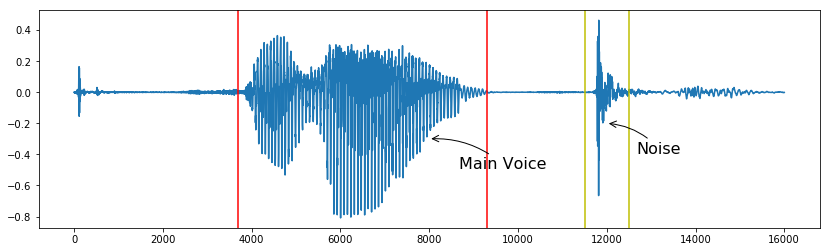

In [55]:
wav_with_multi_peaks = read_wav(train[6][2])

fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(111)
ax.plot(wav_with_multi_peaks)
# Split the wav
ax.axvline(x=3700, c='r')
ax.axvline(x=9300, c='r')
ax.axvline(x=11500, c='y')
ax.axvline(x=12500, c='y')
# Add annotation
plt.annotate('Main Voice', xy=(8000, -0.3), xycoords='data', xytext=(+30, -30),
             textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))
plt.annotate('Noise', xy=(12000, -0.2), xycoords='data', xytext=(+30, -30),
             textcoords='offset points', fontsize=16,
             arrowprops=dict(arrowstyle='->', connectionstyle="arc3,rad=.2"))
plt.show()

### 我们的主要目标是能够将主要的声音提取出来，将其他的声音抹去，采用的方法如下：
首先，将一整段波分成好多个等长的部分，通过平均值来决定是否是有声音或者是没声音

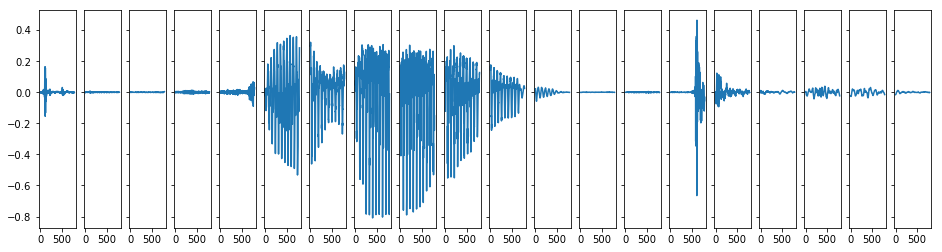

In [67]:
splitted_wavs = np.split(wav_with_multi_peaks, 20)

f, axs = plt.subplots(1, 20, sharex=True, sharey=True) 
f.set_size_inches((16,4))

for i, ax in enumerate(axs):
    ax.plot(splitted_wavs[i])

plt.show()

接下来，我们用每个小段的声音振幅的平均值，来判断这一段时间，是有声音还是没有声音的，用数组来表示的话，就是一串0，1的数字，0代表没有声音，而1代表有声音

In [83]:
# Compute the avg of all segments
wavs_mean = []
for sw in splitted_wavs:
    wavs_mean.append(np.absolute(sw).mean())
wavs_mean = np.array(wavs_mean)

# Check if each segments will be kept or not
seg_keep_array = (wavs_mean > 0.1 * wavs_mean.max()).astype(int)
print(seg_keep_array)

[0 0 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0]


形象一点用图像来表示，图中的绿色部分是有声音的，而蓝色部分是没有声音的

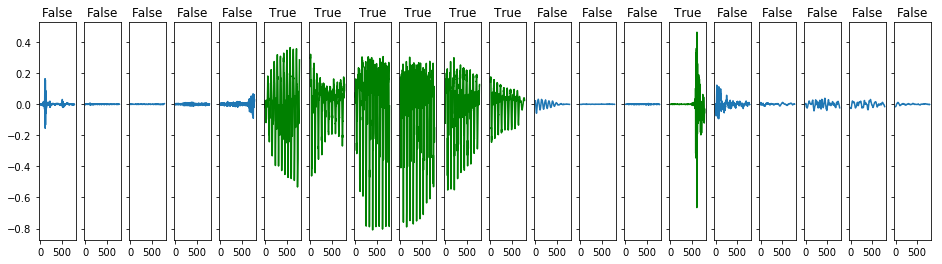

In [84]:
f, axs = plt.subplots(1, 20, sharex=True, sharey=True) 
f.set_size_inches((16,4))

for i, ax in enumerate(axs):
    if seg_keep_array[i] == 1:
        ax.plot(splitted_wavs[i], c='g')
        ax.set_title("True")
    else:
        ax.plot(splitted_wavs[i])
        ax.set_title("False")

plt.show()

很显然，图中最长的有声音的波，即是我们需要的波形，我们现在需要把它找出来

In [86]:
def get_longest_period(seg_keep_array):
    
    def group_consecutives(vals, step=0):
        """Return list of consecutive lists of numbers from vals (number list)."""
        run = []
        result = [run]
        expect = None
        for v in vals:
            if (v == expect) or (expect is None):
                run.append(v)
            else:
                run = [v]
                result.append(run)
            expect = v + step
        return result

    cons_wav = group_consecutives(seg_keep_array)
    cons_wav_length = [sum(wav) for wav in cons_wav]
    start = 0
    end = 0
    for i in range(cons_wav_length.index(max(cons_wav_length))+1):
        if i < cons_wav_length.index(max(cons_wav_length)):
            start += len(cons_wav[i]) 
        end += len(cons_wav[i]) 
    return start, end

start, end = get_longest_period(seg_keep_array)
print("Main voice from seg {} -> seg {}.".format(start, end))

Main voice from seg 5 -> seg 11.


为了防止前面和后面的小波段仍含有部分主声音的信息，但是由于被其他声音中和而均值没有达到阈值，我们都将它加入到最后过滤完的波里面来

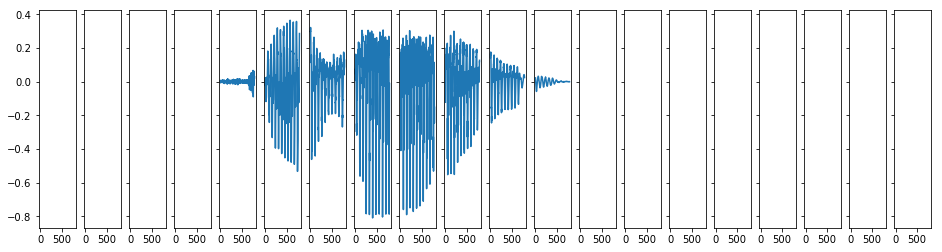

In [91]:
f, axs = plt.subplots(1, 20, sharex=True, sharey=True) 
f.set_size_inches((16,4))

for i, ax in enumerate(axs):
    if i in range(start-1, end+1):
        ax.plot(splitted_wavs[i])
    else:
        pass

plt.show()

### 完整的获取主要声音的代码如下

In [15]:
def get_main_voice(wav, filter_threshold=0.1, num_seg=20):
    """ Keep only the main voice in wav
    
    Args:
        wav: The wav data to be processed, in a numeric series list
        filter_threshold: Threshold to be considered as no signal
        num_seg: How many segments we will cut the wav for filtering
        
    Returns:
        wav with only the main voice kept
    """
    
    wav = signal.resample(wav, 16000)
    
    seg_length = 16000 / num_seg
    # Split wav into segements
    splitted_wavs = np.split(wav, num_seg)
    # Compute the avg of all segments
    wavs_mean = []
    for sw in splitted_wavs:
        wavs_mean.append(np.absolute(sw).mean())
    wavs_mean = np.array(wavs_mean)

    # Check if each segments will be kept or not
    # seg_keep_array : [1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0]
    seg_keep_array = (wavs_mean > 0.1 * wavs_mean.max()).astype(int)

    def group_consecutives(vals, step=0):
        """Return list of consecutive lists of numbers from vals (number list)."""
        run = []
        result = [run]
        expect = None
        for v in vals:
            if (v == expect) or (expect is None):
                run.append(v)
            else:
                run = [v]
                result.append(run)
            expect = v + step
        return result

    def get_longest_period(seg_keep_array):
        cons_wav = group_consecutives(seg_keep_array)
        cons_wav_length = [sum(wav) for wav in cons_wav]
        start = 0
        end = 0
        for i in range(cons_wav_length.index(max(cons_wav_length))+1):
            if i < cons_wav_length.index(max(cons_wav_length)):
                start += len(cons_wav[i]) 
            end += len(cons_wav[i]) 
        return start, end

    # Find the longgest keep period
    # [1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 0] -> 5, 8 (longest continunous 1)
    start, end = get_longest_period(seg_keep_array)
    if start > 1:
        start = (start-1)
    if end < num_seg -1:
        end = (end+1)

    keeped_wav = wav[int(seg_length*start):int(seg_length*end)]
    return keeped_wav

来看看这个代码的处理的结果如何

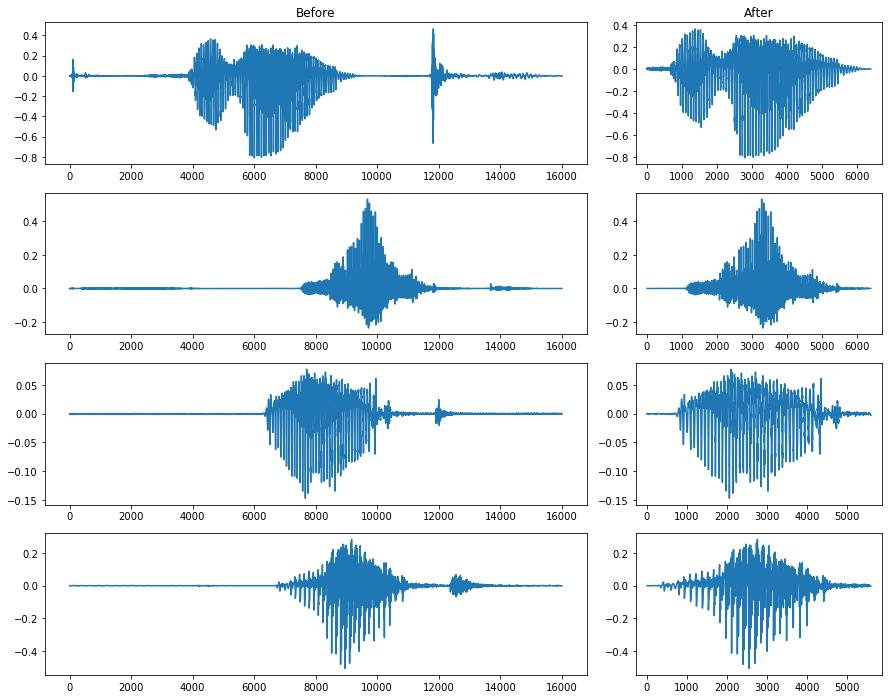

In [103]:
wav_1 = read_wav(train[6][2])
wav_2 = read_wav(train[17][2])
wav_3 = read_wav(train[19][2])
wav_4 = read_wav(train[20][2])

wav_1_main = get_main_voice(wav_1)
wav_2_main = get_main_voice(wav_2)
wav_3_main = get_main_voice(wav_3)
wav_4_main = get_main_voice(wav_4)


fig = plt.figure()
fig.set_size_inches((15,12))

ax11 = plt.subplot2grid( (4,3), (0,0), colspan=2, rowspan=1 )
ax12 = plt.subplot2grid( (4,3), (0,2), colspan=1, rowspan=1 )
ax11.set_title("Before")
ax12.set_title("After")
ax11.plot(wav_1)
ax12.plot(wav_1_main)

ax21 = plt.subplot2grid( (4,3), (1,0), colspan=2, rowspan=1 )
ax22 = plt.subplot2grid( (4,3), (1,2), colspan=1, rowspan=1 )
ax21.plot(wav_2)
ax22.plot(wav_2_main)

ax31 = plt.subplot2grid( (4,3), (2,0), colspan=2, rowspan=1 )
ax32 = plt.subplot2grid( (4,3), (2,2), colspan=1, rowspan=1 )
ax31.plot(wav_3)
ax32.plot(wav_3_main)

ax41 = plt.subplot2grid( (4,3), (3,0), colspan=2, rowspan=1 )
ax42 = plt.subplot2grid( (4,3), (3,2), colspan=1, rowspan=1 )
ax41.plot(wav_4)
ax42.plot(wav_4_main)

plt.show()

# 预处理二：移除前面和后面的空白音段

In [104]:
def remove_muted(wav, muted_rate=0.05):
    """ Remove muted periods at the begining or end
    
    Args:
        wav: data to be processed, a numeric series
        muted_rate: under which the voice will be considered as muted,
            threshold = max_voice * muted_rate
            
    Returns:
        wav without muted part at the begining or end
    """
    
    max_voice = wav.max()
    threshold = max_voice * muted_rate
    
    keep_wav = np.array(np.absolute(wav)>threshold)
    reverse_keep_wav = np.flip(keep_wav, 0)
    start = list(keep_wav).index(True)
    end = wav.size - list(reverse_keep_wav).index(True)
    
    return wav[start:end]

看看代码的处理效果如何

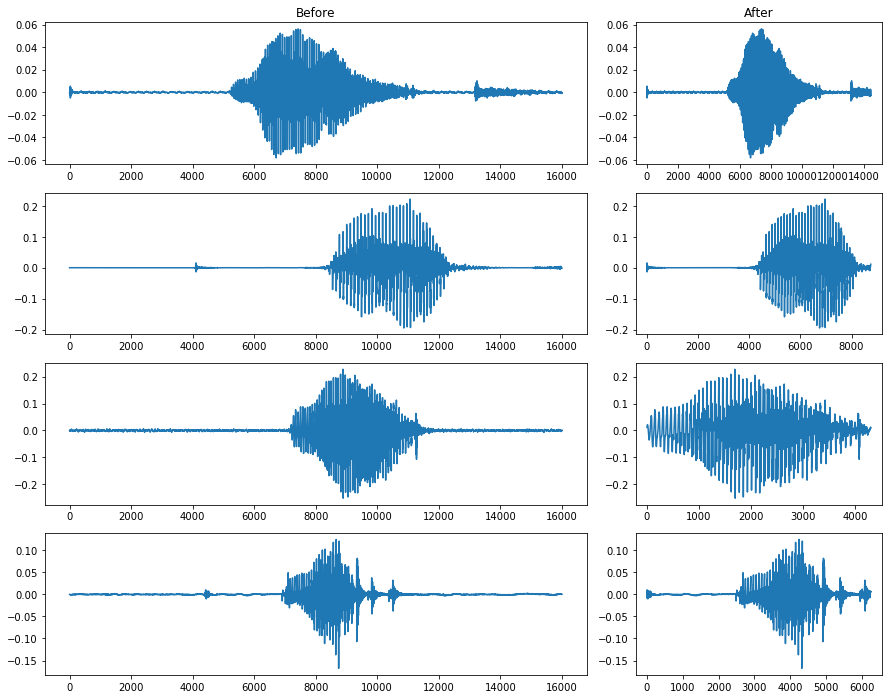

In [106]:
wav_1 = read_wav(train[0][2])
wav_2 = read_wav(train[1][2])
wav_3 = read_wav(train[2][2])
wav_4 = read_wav(train[3][2])

wav_1_main = remove_muted(wav_1)
wav_2_main = remove_muted(wav_2)
wav_3_main = remove_muted(wav_3)
wav_4_main = remove_muted(wav_4)


fig = plt.figure()
fig.set_size_inches((15,12))

ax11 = plt.subplot2grid( (4,3), (0,0), colspan=2, rowspan=1 )
ax12 = plt.subplot2grid( (4,3), (0,2), colspan=1, rowspan=1 )
ax11.set_title("Before")
ax12.set_title("After")
ax11.plot(wav_1)
ax12.plot(wav_1_main)

ax21 = plt.subplot2grid( (4,3), (1,0), colspan=2, rowspan=1 )
ax22 = plt.subplot2grid( (4,3), (1,2), colspan=1, rowspan=1 )
ax21.plot(wav_2)
ax22.plot(wav_2_main)

ax31 = plt.subplot2grid( (4,3), (2,0), colspan=2, rowspan=1 )
ax32 = plt.subplot2grid( (4,3), (2,2), colspan=1, rowspan=1 )
ax31.plot(wav_3)
ax32.plot(wav_3_main)

ax41 = plt.subplot2grid( (4,3), (3,0), colspan=2, rowspan=1 )
ax42 = plt.subplot2grid( (4,3), (3,2), colspan=1, rowspan=1 )
ax41.plot(wav_4)
ax42.plot(wav_4_main)

plt.show()

# 预处理三：移除前面和后面的空白音段

In [110]:
def re_sample(wav, sample_size=4000):
    """ Re sample wav data
    
    Args:
        wav: wav data to be processed, a numeric series
        sample_size: number of samples of final returned wav
        
    Returns:
        sampled wav data
    """
    return signal.resample(wav, sample_size)

# 来看一组全套的处理之后的波形情况

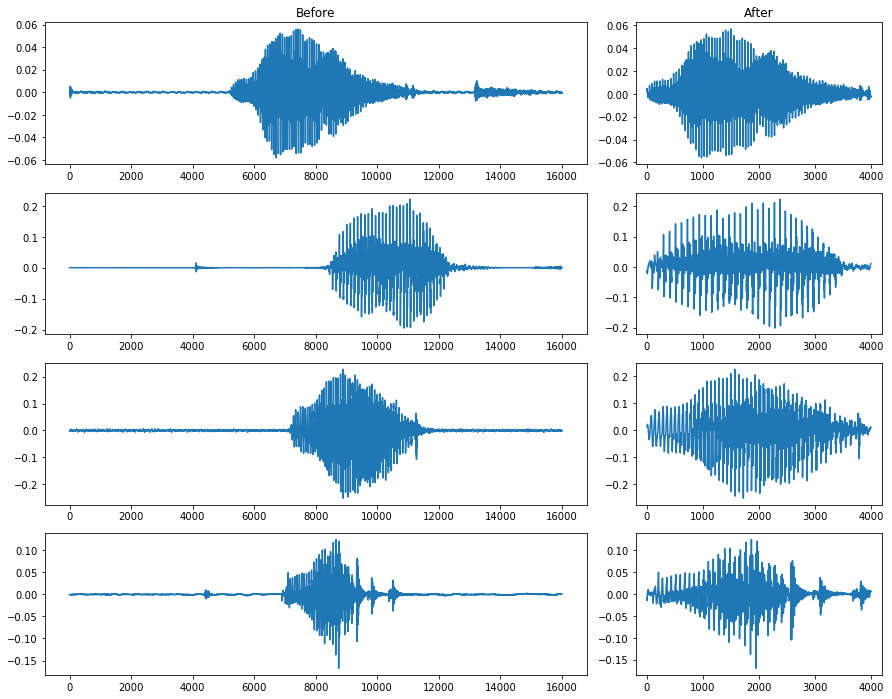

In [111]:
wav_1_before = read_wav(train[0][2])
wav_2_before = read_wav(train[1][2])
wav_3_before = read_wav(train[2][2])
wav_4_before = read_wav(train[3][2])

wav_1_after = get_main_voice(wav_1)
wav_2_after = get_main_voice(wav_2)
wav_3_after = get_main_voice(wav_3)
wav_4_after = get_main_voice(wav_4)

wav_1_after = remove_muted(wav_1_after)
wav_2_after = remove_muted(wav_2_after)
wav_3_after = remove_muted(wav_3_after)
wav_4_after = remove_muted(wav_4_after)

wav_1_after = re_sample(wav_1_after)
wav_2_after = re_sample(wav_2_after)
wav_3_after = re_sample(wav_3_after)
wav_4_after = re_sample(wav_4_after)


fig = plt.figure()
fig.set_size_inches((15,12))

ax11 = plt.subplot2grid( (4,3), (0,0), colspan=2, rowspan=1 )
ax12 = plt.subplot2grid( (4,3), (0,2), colspan=1, rowspan=1 )
ax11.set_title("Before")
ax12.set_title("After")
ax11.plot(wav_1_before)
ax12.plot(wav_1_after)

ax21 = plt.subplot2grid( (4,3), (1,0), colspan=2, rowspan=1 )
ax22 = plt.subplot2grid( (4,3), (1,2), colspan=1, rowspan=1 )
ax21.plot(wav_2_before)
ax22.plot(wav_2_after)

ax31 = plt.subplot2grid( (4,3), (2,0), colspan=2, rowspan=1 )
ax32 = plt.subplot2grid( (4,3), (2,2), colspan=1, rowspan=1 )
ax31.plot(wav_3_before)
ax32.plot(wav_3_after)

ax41 = plt.subplot2grid( (4,3), (3,0), colspan=2, rowspan=1 )
ax42 = plt.subplot2grid( (4,3), (3,2), colspan=1, rowspan=1 )
ax41.plot(wav_4_before)
ax42.plot(wav_4_after)

plt.show()

## 完整的代码见preprocessing.py